<a href="https://colab.research.google.com/github/ThomasL642/Generative-Adversarial-Networks/blob/main/Celeb_A_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from glob import glob
import keras
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, Cropping2D, Maximum
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.layers.convolutional import Conv2DTranspose, Conv2D

In [ ]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/DATA/CelebANumpy.npy')

In [ ]:
print(len(data))

10000


In [ ]:
IMG_WIDTH = 89
IMG_HEIGHT = 109
random_dim = 100
np.random.seed(512)

In [ ]:
x_train = data

print(np.asarray(x_train).shape)

(10000, 109, 89, 3)


In [ ]:
def get_optimizer():
  return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
  generator = Sequential()

  generator.add(Dense(14*12*40, input_dim = random_dim,kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Reshape((14, 12, 40)))

  generator.add(Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='tanh'))

  generator.add(Cropping2D(cropping=((1,2),(3,4))))

  return generator

def get_discriminator(optimizer):

  discriminator = Sequential()

  discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(109,89, 3)))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.02))
  
  discriminator.add(Conv2D(128, (5, 5), strides=(3, 4), padding='same'))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.02))
  
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation= "sigmoid",))
  discriminator.compile(loss="BinaryCrossentropy", optimizer=optimizer)

  return discriminator

In [ ]:
#print(generator.summary())
#print(discriminator.summary())

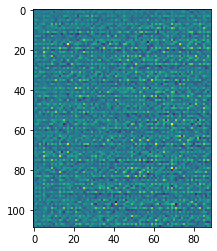

In [ ]:
generator = get_generator(optimizer='adam')

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss="binary_crossentropy", optimizer=optimizer)
  return gan

In [ ]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 109, 89, 3)
  generated_images += 1
  generated_images /= 2

  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation="nearest")
    plt.axis("off")
  plt.tight_layout()
  plt.savefig("gan_generated_image_epoch_%d.png" % epoch)

In [ ]:
print(_)

AxesImage(132.629,36;177.543x217.44)


In [ ]:
from tqdm import tqdm
def train(epochs=1, batch_size=100):
  x_train = data
  batch_count = x_train.shape[0] / batch_size
  adam = get_optimizer()
  generator = get_generator(adam)
  discriminator = get_discriminator(adam)
  gan = get_gan_network(discriminator, random_dim, generator, adam)
  #random noise and images
  for e in range(1, epochs+1):
    print("-"*15,"Epoch %d" % e, "-"*15)
    for _ in tqdm(range(int(batch_count))):
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

      #generate fake images
      generated_images = generator.predict(noise)
      #print(np.asarray(image_batch).shape)
      #print(np.asarray(generated_image).shape)
      X = np.concatenate([image_batch, generated_images])

      #labels for fake + real
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9

      discriminator.trainable = True 
      discriminator.train_on_batch(X, y_dis)

      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)

    if e == 1 or e % 160 == 0:
      plot_generated_images(e, generator)

In [ ]:
train(1600,100)